# 準備

In [1]:
# from google.colab import userdata
from dotenv import load_dotenv
import os
load_dotenv()

# OpenAI API キーの設定
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

In [ ]:
# !pip install -q langchain langgraph langchain-openai langchain-community langchain-experimental

# 4.3. マルチエージェントの活用


## 4.3.1. 数学の問題を解かせよう

In [ ]:
# !pip install -q sympy

In [3]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    problem: str
    first_flag: bool
    end_flag: bool

In [3]:
import re
from langchain_experimental.utilities import PythonREPL
from langchain_core.messages import HumanMessage

#1 Python実行用のツール
repl = PythonREPL()

#2 コード部分を抜き出す関数
def extract_code(input_string: str):
    pattern = r"```(.*?)```"
    match = re.findall(pattern, input_string, flags=re.DOTALL)

    queries = ""
    for m in match:
        query = m.replace("python", "").strip()
        queries += query + "\n"
    return queries

#3 ユーザープロキシエージェントの定義
INITIAL_PROMPT = """\
Pythonを使って数学の問題を解いてみましょう。

クエリ要件：
常に出力には'print'関数を使用し、小数ではなく分数や根号形式を使用してください。
sympyなどのパッケージを利用しても構いません。
以下のフォーマットに従ってコードを書いてください。
```python
# あなたのコード
```

まず、問題を解くための主な考え方を述べてください。問題を解くためには以下の3つの方法から選択できます：
ケース1：問題が直接Pythonコードで解決できる場合、プログラムを書いて解決してください。必要に応じてすべての可能な配置を列挙しても構いません。
ケース2：問題が主に推論で解決できる場合、自分で直接解決してください。
ケース3：上記の2つの方法では対処できない場合、次のプロセスに従ってください：
1. 問題をステップバイステップで解決する（ステップを過度に細分化しないでください）。
2. Pythonを使って問い合わせることができるクエリ（計算や方程式など）を取り出します。
3. 結果を私に教えてください。
4. 結果が正しいと思う場合は続行してください。結果が無効または予期しない場合は、クエリまたは推論を修正してください。

すべてのクエリが実行され、答えを得た後、答えを \\boxed{{}} に入れてください。
答え以外、例えば変数を\\boxed{{}}に入れたり、\\boxed{{}}を単体で使用しないで下さい。
\\boxed{{}}の有無で答えが出たかを管理しています。最終的な答えが出た時以外は、\\boxed{{}}を使用しないでください。
回答が得られた場合は、シンプルに表示して下さい。追加の出力などはしないでください。

問題文：{problem}
"""

def user_proxy_agent(state: State):
    if state["first_flag"]:
        message = INITIAL_PROMPT.format(problem=state["problem"])
    else:
        last_message = state["messages"][-1].content
        code = extract_code(last_message)
        if code:
            message = repl.run(code)
        else:
            message = "続けてください。クエリが必要になるまで問題を解き続けてください。（答えが出た場合は、\\boxed{{}} に入れてください。）",
    message = HumanMessage(message)
    return {"messages": [message], "first_flag": False}

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

# 回答を抜き出す関数
def extract_boxed(input_string: str):
    pattern = r"\\boxed\{.*?\}"
    matches = re.findall(pattern, input_string)
    return [m.replace("\\boxed{", "").replace("}", "") for m in matches]

#  LLMエージェントを定義した関数
def llm_agent(state: State):
    message = llm.invoke(state["messages"])
    content = message.content
    boxed = extract_boxed(content)
    end_flag = False
    if boxed:
        end_flag = True
    return {"messages": [message], "end_flag": end_flag}

In [5]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

graph_builder.add_node("llm_agent", llm_agent)
graph_builder.add_node("user_proxy_agent", user_proxy_agent)

graph_builder.add_edge(START, "user_proxy_agent")
graph_builder.add_conditional_edges(
    "llm_agent",
    lambda state: state["end_flag"],
    {True: END, False: "user_proxy_agent"}
)
graph_builder.add_edge("user_proxy_agent", "llm_agent")

graph = graph_builder.compile()

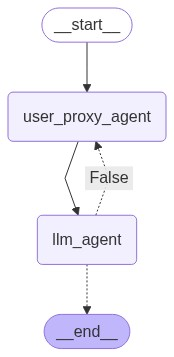

In [6]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
problem = """\
問題: 偽の金塊は、コンクリートの立方体を金色のペイントで覆うことによって作られます。
ペイントのコストは立方体の表面積に比例し、コンクリートのコストは体積に比例します。
1インチの立方体を作るコストが$1.30であり、2インチの立方体を作るコストが$6.80であるとき、3インチの立方体を作るコストはいくらになりますか？"""


for event in graph.stream({"problem": problem, "first_flag": True}):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================ Human Message =================================

Pythonを使って数学の問題を解いてみましょう。

クエリ要件：
常に出力には'print'関数を使用し、小数ではなく分数や根号形式を使用してください。
sympyなどのパッケージを利用しても構いません。
以下のフォーマットに従ってコードを書いてください。
```python
# あなたのコード
```

まず、問題を解くための主な考え方を述べてください。問題を解くためには以下の3つの方法から選択できます：
ケース1：問題が直接Pythonコードで解決できる場合、プログラムを書いて解決してください。必要に応じてすべての可能な配置を列挙しても構いません。
ケース2：問題が主に推論で解決できる場合、自分で直接解決してください。
ケース3：上記の2つの方法では対処できない場合、次のプロセスに従ってください：
1. 問題をステップバイステップで解決する（ステップを過度に細分化しないでください）。
2. Pythonを使って問い合わせることができるクエリ（計算や方程式など）を取り出します。
3. 結果を私に教えてください。
4. 結果が正しいと思う場合は続行してください。結果が無効または予期しない場合は、クエリまたは推論を修正してください。

すべてのクエリが実行され、答えを得た後、答えを \boxed{} に入れてください。
答え以外、例えば変数を\boxed{}に入れたり、\boxed{}を単体で使用しないで下さい。
\boxed{}の有無で答えが出たかを管理しています。最終的な答えが出た時以外は、\boxed{}を使用しないでください。
回答が得られた場合は、シンプルに表示して下さい。追加の出力などはしないでください。

問題文：問題: 偽の金塊は、コンクリートの立方体を金色のペイントで覆うことによって作られます。
ペイントのコストは立方体の表面積に比例し、コンクリートのコストは体積に比例します。
1インチの立方体を作るコストが$1.30であり、2インチの立方体を作るコストが$6.80であるとき、3インチの立方体を作るコストはいくらになりますか？

=============================

## 4.3.2. 議論させてみよう

In [12]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    debate_topic: str
    judged: bool
    round: int
     

from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    debate_topic: str
    judged: bool
    round: int

In [20]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

def cot_agent(
    state: State,
):
    system_message = (
        "与えられた議題に対し、ステップバイステップで考えてから回答してください。"
        "議題：{debate_topic}"
    )
    system_message = SystemMessage(
        system_message.format(debate_topic=state["debate_topic"])
    )
    message = HumanMessage(
        content=llm.invoke([system_message]).content, name="CoT"
    )

    return {"messages": [message]}


In [14]:
from langchain_core.messages import HumanMessage, SystemMessage
import functools

def debater(
    state: State,
    name: str,
    position: str,
):
    system_message = (
        "あなたはディベーターです。ディベート大会へようこそ。"
        "私たちの目的は正しい答えを見つけることですので、お互いの視点に完全に同意する必要はありません。"
        "ディベートのテーマは以下の通りです：{debate_topic}"
        ""
        "{position}"
    )

    debate_topic = state["debate_topic"]
    system_message = SystemMessage(
        system_message.format(debate_topic=debate_topic, position=position)
    )
    message = HumanMessage(
        content=llm.invoke([system_message, *state["messages"]]).content,
        name=name,
    )
    return {"messages": [message]}


affirmative_debator = functools.partial(
    debater,
    name="Affirmative_Debater",
    position="あなたは肯定側です。あなたの見解を簡潔に述べてください。否定側の意見が与えられた場合は、それに反対して理由を簡潔に述べてください。"
)
negative_debator = functools.partial(
    debater,
    name="Negative_Debater",
    position="あなたは否定側です。肯定側の意見に反対し、あなたの理由を簡潔に説明してください。"
)

In [15]:
from pydantic import BaseModel, Field
from langchain_core.messages import AIMessage


class JudgeSchema(BaseModel):
    judged: bool = Field(..., description="勝者が決まったかどうか")
    answer: str = Field(description="議題に対する結論とその理由")


def judger(state: State):
    system_message = (
        "あなたは司会者です。"
        "ディベート大会に2名のディベーターが参加します。"
        "彼らは{debate_topic}について自分の回答を発表し、それぞれの視点について議論します。"
        "各ラウンドの終わりに、あなたは両者の回答を評価していき、ディベートの勝者を判断します。"
        "判定が難しい場合は、次のラウンドで判断してください。"
    )
    system_message = SystemMessage(
        system_message.format(debate_topic=state["debate_topic"])
    )

    llm_with_format = llm.with_structured_output(JudgeSchema)
    res = llm_with_format.invoke([system_message, *state["messages"]])
    messages = []

    if res.judged:
        message = HumanMessage(res.answer)
        messages.append(message)
    return {
        "messages": messages,
             "judged": res.judged
    }


In [16]:
def round_monitor(state: State, max_round: int):
    round = state["round"] + 1
    if state["round"] < max_round:
        return {"round": round}
    else:
        return {
            "messages": [HumanMessage(
                "最終ラウンドなので、勝者を決定し、議題に対する結論とその理由を述べてください。"
            )],
            "round": round,
        }

round_monitor = functools.partial(round_monitor, max_round=3)

In [17]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

graph_builder.add_node("cot_agent", cot_agent)
graph_builder.add_node("affirmative_debator", affirmative_debator)
graph_builder.add_node("negative_debator", negative_debator)
graph_builder.add_node("judger", judger)
graph_builder.add_node("round_monitor", round_monitor)

graph_builder.add_edge(START, "cot_agent")
graph_builder.add_edge("cot_agent", "affirmative_debator")
graph_builder.add_edge("affirmative_debator", "negative_debator")
graph_builder.add_edge("negative_debator", "round_monitor")
graph_builder.add_edge("round_monitor", "judger")
graph_builder.add_conditional_edges(
    "judger",
    lambda state: state["judged"],
    {True: END, False: "affirmative_debator"}
)

graph = graph_builder.compile()

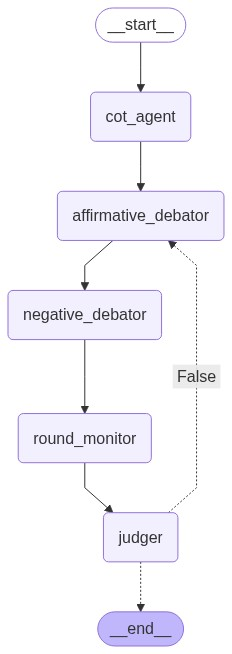

In [18]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
inputs = {
    "messages": [],
    "debate_topic": "戦争は必要か？",
    "judged": False,
    "round": 0,
}

for event in graph.stream(inputs):
    for value in event.values():
        try:
            value["messages"][-1].pretty_print()
        except:
            pass

================================ Human Message =================================
Name: CoT

議題「戦争は必要か？」についてステップバイステップで考えてみます。

### ステップ1: 戦争の定義
まず、戦争とは何かを明確にする必要があります。戦争は、国家または集団間の武力衝突であり、通常は政治的、経済的、または社会的目的を達成するために行われます。

### ステップ2: 戦争の目的
戦争はさまざまな目的で行われます。例えば：
- 領土拡張
- 資源の獲得
- 政治的体制の変更
- 自衛
- 人道的介入

これらの目的が正当化されるかどうかを考える必要があります。

### ステップ3: 戦争の影響
次に、戦争がもたらす影響を考慮します。
- **人命の喪失**: 戦争は多くの人々の命を奪います。
- **経済的損失**: 戦争は経済に深刻なダメージを与えます。
- **社会的混乱**: 戦争はコミュニティを分断し、社会的な不安を引き起こします。
- **長期的なトラウマ**: 戦争の影響は世代を超えて残ることがあります。

### ステップ4: 戦争の代替手段
次に、戦争の代わりに何ができるかを考えます。
- **外交**: 交渉や対話を通じて問題を解決する。
- **国際機関の活用**: 国連などの国際組織を通じて平和的な解決を目指す。
- **経済制裁**: 政治的な圧力をかけるために経済制裁を利用する。

### ステップ5: 戦争が必要な場合
戦争が必要とされる状況もあります。例えば、自国の防衛や人道的介入が正当化される場合です。しかし、これらのケースでも、戦争が唯一の選択肢であるかどうかを慎重に評価する必要があります。

### 結論
戦争は極端な手段であり、多くの悲劇をもたらす可能性があります。そのため、戦争が本当に必要かどうかは、その状況によります。基本的には、平和的な解決策を優先すべきですが、自衛や人道的理由でやむを得ない場合もあります。戦争を避けるための努力が常に重要です。
================================ Human Message =================================
Name: Affir






















## 4.3.3. 回答を洗練させよう

In [ ]:
# !pip install -q langchain-google-genai
# !pip install -q langchain-anthropic

In [ ]:
from google.colab import userdata
import os

# Google API キーの設定
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

# Anthropic API キーの設定
os.environ["ANTHROPIC_API_KEY"] = userdata.get('ANTHROPIC_API_KEY')

In [84]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_google_genai import ChatGoogleGenerativeAI

llm_openai = ChatOpenAI(model="gpt-4o-mini")
llm_anthropic = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_google = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

In [86]:
from typing_extensions import TypedDict
from typing import Annotated

from langgraph.graph.message import add_messages

from langchain_core.messages import HumanMessage, AIMessage, SystemMessage


class State(TypedDict):
    human_message: HumanMessage
    messages: Annotated[list, add_messages]
    prev_messages: list[AIMessage]
    layer_cnt: int

In [87]:
from functools import partial
from typing import Union


aggregater_system_message_template = """\
最新のユーザーの質問に対して、さまざまなLLMからの回答が提供されています。あなたの任務は、これらの回答を統合して、単一の高品質な回答を作成することです。
提供された回答に含まれる情報を批判的に評価し、一部の情報が偏っていたり誤っていたりする可能性があることを認識することが重要です。
回答を単に複製するのではなく、正確で包括的な返答を提供してください。
回答が良く構造化され、一貫性があり、最高の精度と信頼性の基準を満たすようにしてください。

{prev_messages}"""

def agent(state: State, llm: Union[ChatOpenAI, ChatAnthropic, ChatGoogleGenerativeAI], name: str):
    input_messages = []
    if len(state["prev_messages"]) > 0:
        prev_messages = [f"{i+1}. {message.content}" for i, message in enumerate(state["prev_messages"])]
        prev_messages = "\n".join(prev_messages)

        aggregater_system_message = SystemMessage(
            aggregater_system_message_template.format(prev_messages=prev_messages),
        )

        input_messages.append(aggregater_system_message)

    input_messages.append(state["human_message"])

    message = llm.invoke(input_messages)
    message.name = name

    return {"messages": [message]}

agent_openai = partial(agent, llm=llm_openai, name="openai")
agent_anthropic = partial(agent, llm=llm_anthropic, name="anthropic")
agent_google = partial(agent, llm=llm_google, name="google")

In [88]:
def update(state: State, num_agents: int):
    return {
        "prev_messages": state["messages"][-num_agents:],
        "layer_cnt": state["layer_cnt"] + 1
    }

In [89]:
def router(
    state: State,
    num_layers: int,
    agent_name_list: list[str]
):
    if state["layer_cnt"] < num_layers:
        return agent_name_list
    else:
        return "final_agent"

In [90]:
from langgraph.graph import StateGraph, START, END

num_layers = 3

graph_builder = StateGraph(State)

agent_dict = {
    "openai": agent_openai,
    "anthropic": agent_anthropic,
    "google": agent_google,
}

graph_builder.add_node(
    "update",
    partial(update, num_agents=len(agent_dict))
)
graph_builder.add_node("final_agent", agent_dict["openai"])

for agent_name, agent in agent_dict.items():
    graph_builder.add_node(agent_name, agent)
    graph_builder.add_edge(START, agent_name)
    graph_builder.add_edge(agent_name, "update")

agent_name_list = list(agent_dict.keys())
graph_builder.add_conditional_edges(
    "update",
    partial(router, num_layers=num_layers, agent_name_list=agent_name_list),
    agent_name_list + ["final_agent"]
)
graph_builder.add_edge("final_agent", END)

graph = graph_builder.compile()

In [ ]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
human_message = HumanMessage("マルチエージェントについて教えて")

state = {
    "human_message": human_message,
    "messages": [],
    "prev_messages": [],
    "layer_cnt": 1
}

print("#################### Layer 1 ####################")
for event in graph.stream(state):
    for value in event.values():
        if "messages" in value:
            value["messages"][-1].pretty_print()
        if "layer_cnt" in value:
            print(f"\n\n#################### Layer {value['layer_cnt']} ####################")